In [1]:
%matplotlib inline
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import matplotlib
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [2]:
class BollingerBands(bt.Strategy):
    params = (('period', 30),('d_factor', 3),)
    
    def log(self, text, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s %s" %(dt.isoformat(), text))
        
    def __init__(self):
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.bband = btind.BollingerBands(self.datas[0], period=self.p.period, devfactor=self.p.d_factor)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'Buy Executed, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('Sell Executed, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('Operation Profit, GROSS %.2f, NET %.2f' %(trade.pnl, trade.pnlcomm))
    
    def next(self):
        if self.order:
            return
        if not self.position:
            if self.data.close < self.bband.lines.bot:
                self.log('Buy Create, %.2f' % self.data.close[0])
                self.order = self.buy()
            elif self.data.close > self.bband.lines.top:
                self.log('Sell Create, %.2f' % self.data.close[0])
                self.order = self.sell()
        else:
            if self.position.size>0 and self.data.close >= self.bband.lines.mid:
                self.log('Sell Create, %.2f' % self.data.close[0])
                self.order = self.close()
            elif self.position.size<0 and self.data.close <= self.bband.lines.mid:
                self.log('Buy Create, %.2f' % self.data.close[0])
                self.order = self.close()

In [3]:
cerebro = bt.Cerebro()
data = btfeeds.YahooFinanceCSVData(
        dataname = 'orcl-1995-2014.txt',
        fromdate=datetime.datetime(2004, 1, 1),
        todate=datetime.datetime(2008, 12, 31),
        reverse=False
    )

In [4]:
cerebro.adddata(data)
cerebro.addstrategy(BollingerBands)
cerebro.broker.setcash(100000.0)  
cerebro.broker.setcommission(commission=0.01)
start_portfolio_value = cerebro.broker.getvalue()

In [5]:
cerebro.run()
end_portfolio_value = cerebro.broker.getvalue()
print("Starting portfolio value: %s \nEnding portfolio value: %s \nProfit: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))

2004-09-15 Sell Create, 10.08
2004-09-16 Sell Executed, Price: 10.01, Cost: -10.01, Comm 0.10
2004-11-22 Buy Create, 11.28
2004-11-23 Buy Executed, Price: 11.21, Cost: -10.01, Comm 0.11
2004-11-23 Operation Profit, GROSS -1.20, NET -1.41
2004-12-13 Sell Create, 13.01
2004-12-14 Sell Executed, Price: 12.86, Cost: -12.86, Comm 0.13
2005-01-04 Buy Create, 11.62
2005-01-05 Buy Executed, Price: 11.59, Cost: -12.86, Comm 0.12
2005-01-05 Operation Profit, GROSS 1.27, NET 1.03
2005-06-29 Sell Create, 12.07
2005-06-30 Sell Executed, Price: 12.06, Cost: -12.06, Comm 0.12
2005-08-03 Buy Create, 11.90
2005-08-04 Buy Executed, Price: 11.79, Cost: -12.06, Comm 0.12
2005-08-04 Operation Profit, GROSS 0.27, NET 0.03
2005-09-23 Buy Create, 11.07
2005-09-26 Buy Executed, Price: 11.15, Cost: 11.15, Comm 0.11
2005-10-24 Sell Create, 11.40
2005-10-25 Sell Executed, Price: 11.32, Cost: 11.15, Comm 0.11
2005-10-25 Operation Profit, GROSS 0.17, NET -0.05
2006-09-20 Sell Create, 15.95
2006-09-21 Sell Executed,

<IPython.core.display.Javascript object>


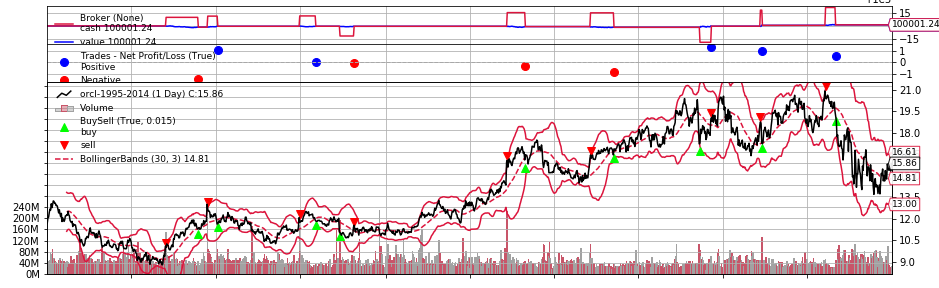

[[<Figure size 432x288 with 4 Axes>]]

In [6]:
cerebro.plot()